In [325]:
import numpy as np
import math
from math import e
import pandas as pd
import qutip as qt

In [326]:
# define Pauli matrices
I = np.matrix([[1,0],[0,1]])
X = np.matrix([[0,1],[1,0]])
Y = np.matrix([[0,0-1j],[0+1j,0]])
Z = np.matrix([[1,0],[0,-1]])

In [327]:
# any linear combination of I,X,Y,Z
def generate_combination(i,x,y,z):
    return i*I+x*X+y*Y+z*Z

In [328]:
# function for checking whether or not matrix is unitary (all valid hamiltonians are unitary)
def check_unitary(A):
    Adag = A.getH()
    if not (np.array_equal(np.matmul(Adag,A),I) and np.array_equal(np.matmul(A,Adag),I)):
        return False
    return True

In [329]:
def generate_hamiltonian(alpha,beta,gamma,delta):
    term1 = e**((alpha-beta/2-delta/2)*1j)*math.cos(gamma/2)
    term2 = e**((alpha-beta/2+delta/2)*1j)*math.sin(gamma/2)*(-1)
    term3 = e**((alpha+beta/2-delta/2)*1j)*math.sin(gamma/2)
    term4 = e**((alpha+beta/2+delta/2)*1j)*math.cos(gamma/2)
    hamiltonian = np.matrix([[term1,term2],[term3,term4]])
    # we verify that the hamiltonian is unitary, and if it isn't we return the identity
    if check_unitary(hamiltonian):
        return hamiltonian
    else:
        return I

#below are other possible functions to generate unitary matrices, but they do not have as good success rates
'''
def generate_hamiltonian(alpha,beta,xi,zeta):
    first_mat = np.matrix([[math.cos(alpha),-math.sin(alpha)],[math.sin(alpha),math.cos(alpha)]])
    second_mat = np.matrix([[e**((xi)*1j),0],[0,e**((zeta)*1j)]])
    third_mat = np.matrix([[math.cos(beta),math.sin(beta)],[-math.sin(beta),math.cos(beta)]])
    return np.matmul(np.matmul(first_mat,second_mat),third_mat)

def generate_hamiltonian(x,y,z):
    return np.matmul(np.matmul(X**x,Y**y),Z**z)
'''

'\ndef generate_hamiltonian(alpha,beta,xi,zeta):\n    first_mat = np.matrix([[math.cos(alpha),-math.sin(alpha)],[math.sin(alpha),math.cos(alpha)]])\n    second_mat = np.matrix([[e**((xi)*1j),0],[0,e**((zeta)*1j)]])\n    third_mat = np.matrix([[math.cos(beta),math.sin(beta)],[-math.sin(beta),math.cos(beta)]])\n    return np.matmul(np.matmul(first_mat,second_mat),third_mat)\n\ndef generate_hamiltonian(x,y,z):\n    return np.matmul(np.matmul(X**x,Y**y),Z**z)\n'

In [330]:
# change values of alpha, beta, gamma, and delta to see what sort of unitary matrices we return
a=1
b=0.5
c=1
d=0.5
A = generate_hamiltonian(a,b,c,d)

In [331]:
# should always be true
check_unitary(A)

True

In [332]:
# if A is identity, maybe try different values of alpha, beta, gamma, and delta
A

matrix([[ 0.77015115+0.42073549j, -0.25903472-0.40342268j],
        [ 0.25903472+0.40342268j,  0.06207773+0.87538421j]])

In [333]:
# generate random 2 dimensional vector
vec = np.random.rand(2)

In [334]:
vec

array([0.53500428, 0.5826982 ])

In [335]:
def get_magnitude(v):
    return math.sqrt(v[0]**2+v[1]**2)

In [336]:
# change vector to have norm of 1
vec = vec/get_magnitude(vec)

In [337]:
def evolve(v,A):
    return np.matmul(A,v).A1

In [338]:
# v is the inital state as a complex vector with two dimensions
# A is the hamiltonian defining the evolution of the state
# n is the number of evolutions, the number of state vectors in the returned evolution_matrix
def generate_evolution_matrix(v,A,n):
    evolution_matrix = np.array([v,evolve(v,A)])
    v = evolve(evolve(v,A),A)
    for i in range(0,n-2):
        evolution_matrix = np.vstack( (evolution_matrix,np.array([v])) )
        v = evolve(v,A)
    return evolution_matrix

In [339]:
evolution_matrix = generate_evolution_matrix(vec,A,1000)

In [340]:
split_evolution_matrix = np.zeros((evolution_matrix.shape[0],4))

In [341]:
#extract real and imaginary parts out of evolution matrix
for row in range(0,evolution_matrix.shape[0]):
    split_evolution_matrix[row, 0] = np.real(evolution_matrix[row, 0])
    split_evolution_matrix[row, 1] = np.imag(evolution_matrix[row, 0])
    split_evolution_matrix[row, 2] = np.real(evolution_matrix[row, 1])
    split_evolution_matrix[row, 3] = np.imag(evolution_matrix[row, 1])

In [342]:
# export evolution matrix as csv
mat_df = pd.DataFrame(split_evolution_matrix)
mat_df.to_csv("evolution_data.csv")

In [343]:
b = qt.Bloch()
state_matrix = np.empty(1000, dtype=qt.Qobj)
for i in range(0,1000):
    state_matrix[i] = qt.Qobj(evolution_matrix[i])

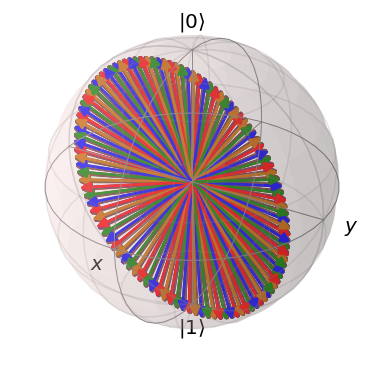

In [344]:
b.add_states(state_matrix)
b.render()